In [ ]:
# Cell 0.1: Imports for real data & model loading
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import time

from src.explanationrunner import ExplanationRunner
from src.dataloader import Mimic, SimulatedSwitch, SimulatedState
from src.explainer.winitexplainers import WinITExplainer
from src.run import Params
import logging
logging.getLogger().setLevel(logging.INFO)


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [2]:


cfg = OmegaConf.load('../config/nb_3_eval.yaml')
argdict = OmegaConf.to_container(cfg, resolve=True)

# argdict = vars(parser.parse_args())
data = argdict['data']
explainers = argdict['explainer']
skip_explain = argdict['skipexplain']
eval_explain = argdict['eval']
train_models = argdict['train']
train_gen = argdict['traingen']
result_file = argdict["resultfile"]
epoch_gen = argdict["epoch_gen"]

device = "cuda" if torch.cuda.is_available() else "cpu"

# parse the arg
params = Params(argdict)
dataset = params.datasets
model_args = params.model_args
model_train_args = params.model_train_args
all_explainer_dict = params.all_explainer_dict
out_path = params.outpath
ckpt_path = params.ckptpath
plot_path = params.plotpath
start_time = time.time()
log = logging.getLogger("Base")
for k, v in argdict.items():
    log.info(f"{k:15}: {v}")
first = True
save_failed = False


# overwrite a few things

base_path = pathlib.Path("/home/WinIT")  # adjust to your repo root


2025-06-11 04:19:52,120     INFO                      Base: data           : spike
2025-06-11 04:19:52,121     INFO                      Base: delay          : 0
2025-06-11 04:19:52,122     INFO                      Base: explainer      : ['winit']
2025-06-11 04:19:52,123     INFO                      Base: cv             : [0, 1, 2, 3, 4]
2025-06-11 04:19:52,124     INFO                      Base: testbs         : 128
2025-06-11 04:19:52,125     INFO                      Base: dataseed       : 1234
2025-06-11 04:19:52,125     INFO                      Base: datapath       : ../data/simulated_spike_data
2025-06-11 04:19:52,126     INFO                      Base: explainerseed  : 2345
2025-06-11 04:19:52,127     INFO                      Base: outpath        : ../output_nb/
2025-06-11 04:19:52,128     INFO                      Base: ckptpath       : ../ckpt/
2025-06-11 04:19:52,129     INFO                      Base: plotpath       : ../plots/
2025-06-11 04:19:52,130     INFO           

In [3]:

dataset.load_data()  # populates dataset.train_loader, dataset.val_loader, etc.

# 2) Create the runner and either train or load a pretrained model
runner = ExplanationRunner(
    dataset=dataset,
    device=device,
    out_path=out_path,
    ckpt_path=ckpt_path,
    plot_path=plot_path
)

# If you do need to train the model:
if train_models:
    runner.init_model(**model_args)
    runner.train_model(**model_train_args, use_all_times=True)
else:
    # Load a saved checkpoint
    runner.init_model(**model_args)
    runner.load_model(use_all_times=True)

print("✔️  Dataset loaded and model ready. ")


/home/WinIT/winit/modeltrainer.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(str(self.model_file_name), map_location=torch.device(self.device))
/home/anac

✔️  Dataset loaded and model ready. 


In [4]:
# Cell 0.4: Train or load the WinIT generators
if train_gen:
    # This will train feature‐generators (WinIT’s internal LSTMs/Gaussian generators)
    runner.train_generators(dataset.train_loader, dataset.val_loader)
else:
    for explainer_name, explainer_dict_list in all_explainer_dict.items():
        for explainer_dict in explainer_dict_list:
            # generate feature importance
            runner.clean_up(clean_importance=True, clean_explainer=True, clean_model=False)
            runner.get_explainers(explainer_name, explainer_dict=explainer_dict)
            runner.set_model_for_explainer(set_eval=explainer_name != "fit")

            if not skip_explain:
                log.info(f"Running Explanations..."
                            f"Data={dataset.get_name()}, Explainer={explainer_name}, Dict={explainer_dict}")

                runner.load_generators()
print("✔️  Generator models are ready. ")


2025-06-11 04:19:57,527     INFO                      Base: Running Explanations...Data=simulated_spike, Explainer=winit, Dict={'window_size': 10, 'joint': False, 'conditional': False, 'usedatadist': False, 'random_state': 2345, 'metric': 'pd'}
/home/WinIT/winit/explainer/generator/generator.py:555: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

✔️  Generator models are ready. 


In [5]:

test_iterator = iter(dataset.test_loader)
x_batch, y_batch = next(test_iterator)  # (batch_size, features, timesteps), (batch_size,)

x_batch = x_batch.to(device)
print(f"✔️  Fetched one batch: x_batch.shape = {x_batch.shape}, y_batch.shape = {y_batch.shape}")

exps = runner.explainers
cv = 4
explainer = exps[cv]

# Cell 0.7: Sanity‐check prediction on our sample
with torch.no_grad():
    p_test = explainer._model_predict(x_batch)
# print("Model output probabilities:", p_test.cpu().numpy())


✔️  Fetched one batch: x_batch.shape = torch.Size([128, 3, 80]), y_batch.shape = torch.Size([128, 80])


/home/anaconda3/envs/winit/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/Context.cpp:208.)
  return F.linear(input, self.weight, self.bias)


Model output probabilities: [[9.99915481e-01 8.45193863e-05]
 [9.99466956e-01 5.33044338e-04]
 [9.99528527e-01 4.71472740e-04]
 [1.91814895e-03 9.98081863e-01]
 [1.87946460e-03 9.98120546e-01]
 [2.41087889e-03 9.97589111e-01]
 [1.97601854e-03 9.98023987e-01]
 [9.99916792e-01 8.32080841e-05]
 [1.66297483e-03 9.98337030e-01]
 [1.18261494e-03 9.98817384e-01]
 [9.99861717e-01 1.38282776e-04]
 [9.98800516e-01 1.19948387e-03]
 [1.56283600e-03 9.98437166e-01]
 [1.31511095e-03 9.98684883e-01]
 [9.99999523e-01 4.76837158e-07]
 [3.88937281e-03 9.96110618e-01]
 [1.55001588e-03 9.98449981e-01]
 [9.99823034e-01 1.76966190e-04]
 [9.99992967e-01 7.03334808e-06]
 [2.18051276e-03 9.97819483e-01]
 [1.98595505e-03 9.98014033e-01]
 [3.35338316e-03 9.96646643e-01]
 [9.99757111e-01 2.42888927e-04]
 [1.04721996e-03 9.98952806e-01]
 [7.45794596e-03 9.92542028e-01]
 [1.79152726e-03 9.98208463e-01]
 [1.36453286e-03 9.98635471e-01]
 [1.37099635e-03 9.98628974e-01]
 [2.21819989e-03 9.97781813e-01]
 [1.45347172e-0

/home/anaconda3/envs/winit/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/Context.cpp:208.)
  return F.linear(input, self.weight, self.bias)


## read importance scores

In [6]:
runner.run_attributes()
runner.save_importance()
importances = runner.importances
log.info("Explanations done.")
# use this to eval and plot importances
df = runner.evaluate_simulated_importance(argdict["aggregate"])

2025-06-11 04:20:14,454     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8937


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:20:24,191     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 9.7269


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:20:35,027     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8271


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:20:45,875     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8420


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:20:56,008     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.1286


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (88, 3, 80, 10) (88, 3, 80, 10) (88, 3, 80, 10)


2025-06-11 04:21:06,978     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.9486


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:21:17,506     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.5214


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:21:28,313     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8023


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:21:39,188     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8705


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:21:49,572     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.3797


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (88, 3, 80, 10) (88, 3, 80, 10) (88, 3, 80, 10)


2025-06-11 04:22:00,590     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 11.0012


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:22:11,540     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.9412


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:22:22,423     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8785


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:22:33,262     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8348


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:22:43,280     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.0118


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (88, 3, 80, 10) (88, 3, 80, 10) (88, 3, 80, 10)


2025-06-11 04:22:54,063     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.7650


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:23:04,886     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8188


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:23:15,619     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.7286


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:23:26,458     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8327


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:23:36,671     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.2086


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (88, 3, 80, 10) (88, 3, 80, 10) (88, 3, 80, 10)


2025-06-11 04:23:47,464     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.7743


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:23:58,312     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.8431


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:24:08,188     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 9.8726


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:24:18,868     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.6757


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (128, 3, 80, 10) (128, 3, 80, 10) (128, 3, 80, 10)


2025-06-11 04:24:29,293     INFO            WinITExplainer: Importance scoring of the batch done: Time elapsed: 10.4204
2025-06-11 04:24:29,311     INFO         ExplanationRunner: Saving file to ../output_nb/gru1layer/simulated_spike/winit_window_10_pd_test_importance_scores_0.pkl
2025-06-11 04:24:29,364     INFO         ExplanationRunner: Saving file to ../output_nb/gru1layer/simulated_spike/winit_window_10_pd_test_importance_scores_1.pkl
2025-06-11 04:24:29,418     INFO         ExplanationRunner: Saving file to ../output_nb/gru1layer/simulated_spike/winit_window_10_pd_test_importance_scores_2.pkl
2025-06-11 04:24:29,453     INFO         ExplanationRunner: Saving file to ../output_nb/gru1layer/simulated_spike/winit_window_10_pd_test_importance_scores_3.pkl
2025-06-11 04:24:29,486     INFO         ExplanationRunner: Saving file to ../output_nb/gru1layer/simulated_spike/winit_window_10_pd_test_importance_scores_4.pkl


attribution done, scores.shape, iSab_array.shape,  IS_array.shape (88, 3, 80, 10) (88, 3, 80, 10) (88, 3, 80, 10)


2025-06-11 04:24:29,519     INFO         ExplanationRunner: Saving extra '0' for CV=iSab to ../output_nb/gru1layer/simulated_spike/iSab_0.pkl
2025-06-11 04:24:29,539     INFO         ExplanationRunner: Saving extra '1' for CV=iSab to ../output_nb/gru1layer/simulated_spike/iSab_1.pkl
2025-06-11 04:24:29,560     INFO         ExplanationRunner: Saving extra '2' for CV=iSab to ../output_nb/gru1layer/simulated_spike/iSab_2.pkl
2025-06-11 04:24:29,582     INFO         ExplanationRunner: Saving extra '3' for CV=iSab to ../output_nb/gru1layer/simulated_spike/iSab_3.pkl
2025-06-11 04:24:29,602     INFO         ExplanationRunner: Saving extra '4' for CV=iSab to ../output_nb/gru1layer/simulated_spike/iSab_4.pkl
2025-06-11 04:24:29,622     INFO         ExplanationRunner: Saving extra '0' for CV=IS to ../output_nb/gru1layer/simulated_spike/IS_0.pkl
2025-06-11 04:24:29,643     INFO         ExplanationRunner: Saving extra '1' for CV=IS to ../output_nb/gru1layer/simulated_spike/IS_1.pkl
2025-06-11 04:

plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_0.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_1.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_2.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_3.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_4.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_5.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_6.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_7.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_8.png
plot saved at:  ../plots/gru1layer/simulated_spike/winit_window_10_pd_mean_cv_0_attributions_9.png
plot saved

/home/anaconda3/envs/winit/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/Context.cpp:208.)
  return F.linear(input, self.weight, self.bias)


plot saved at:  ../plots/gru1layer/simulated_spike/data_0.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_1.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_2.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_3.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_4.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_5.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_6.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_7.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_8.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_9.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_10.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_11.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_12.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_13.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_14.png
plot saved at:  ../plots/gru1layer/simulated_spike/data_15.png
pl

In [19]:
sample_idx = 1
extra_scores = runner.extra_scores
extra_scores['iSab'][cv].shape
extra_scores['IS'][cv].shape


iSab_all = extra_scores['iSab'][cv][sample_idx]   # [key][cv][sample_idx]
IS_all = extra_scores['IS'][cv][sample_idx]   # [key][cv][sample_idx]
scores = importances[cv][sample_idx]
scores.shape


(3, 80, 10)

## Plotting

### Plot @ timestamp

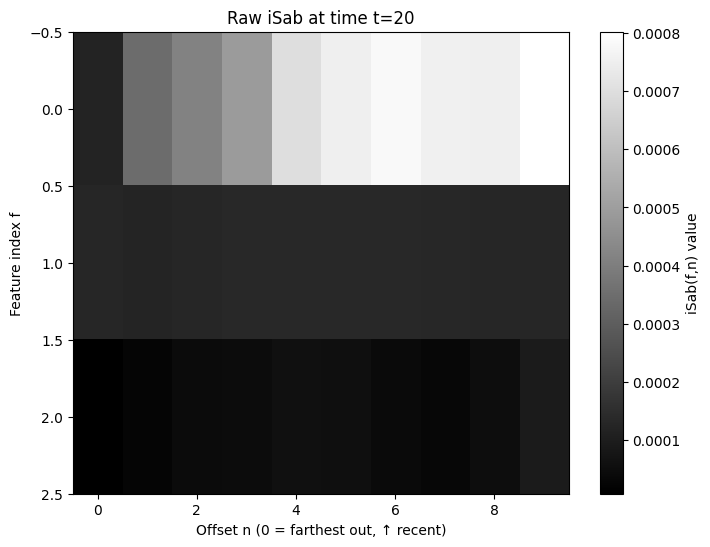

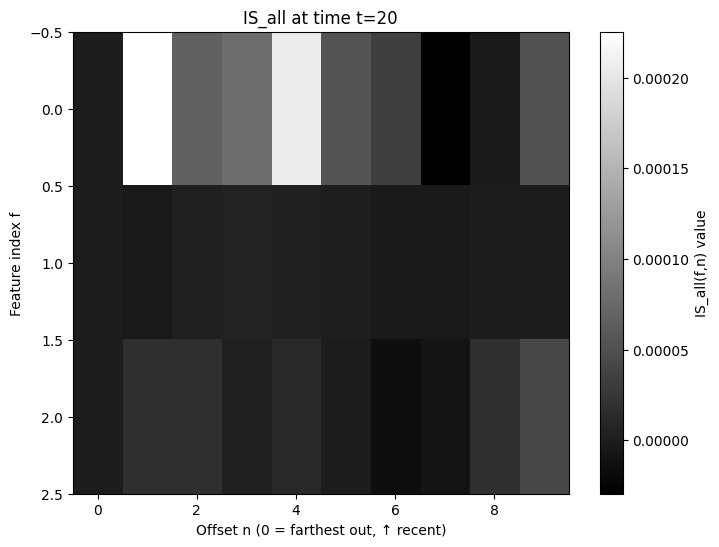

In [21]:
# Cell 3: Visualize iSab at a chosen time t0 (e.g. t0=20) as a heatmap
t0 = 20
data_matrix = iSab_all[:,t0,:]    

plt.figure(figsize=(8, 6))
im = plt.imshow(data_matrix, aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(f,n) value")
plt.xlabel("Offset n (0 = farthest out, ↑ recent)")
plt.ylabel("Feature index f")
plt.title(f"Raw iSab at time t={t0}")
plt.show()


data_matrix = IS_all[:,t0,:]    

plt.figure(figsize=(8, 6))
im = plt.imshow(data_matrix, aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(f,n) value")
plt.xlabel("Offset n (0 = farthest out, ↑ recent)")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time t={t0}")
plt.show()



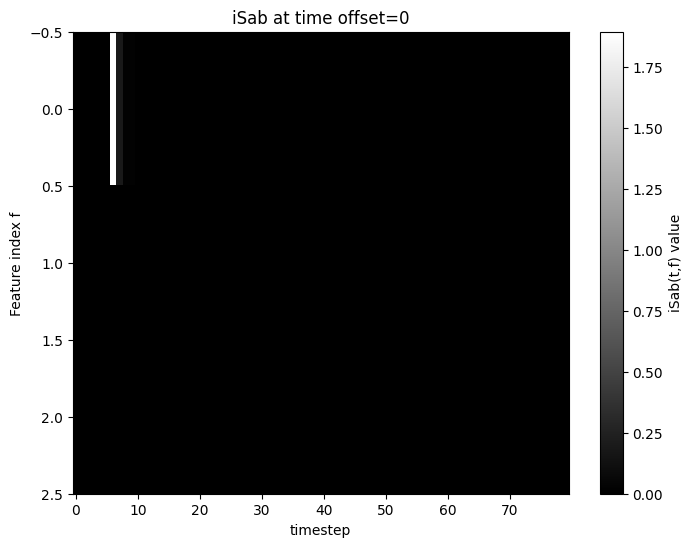

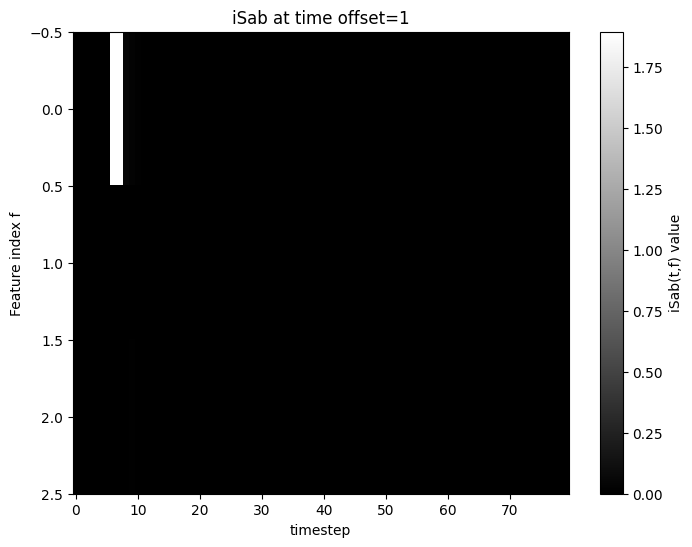

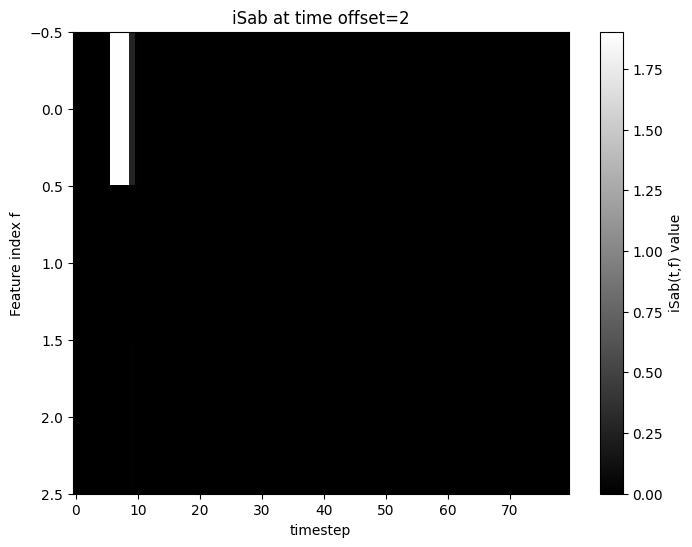

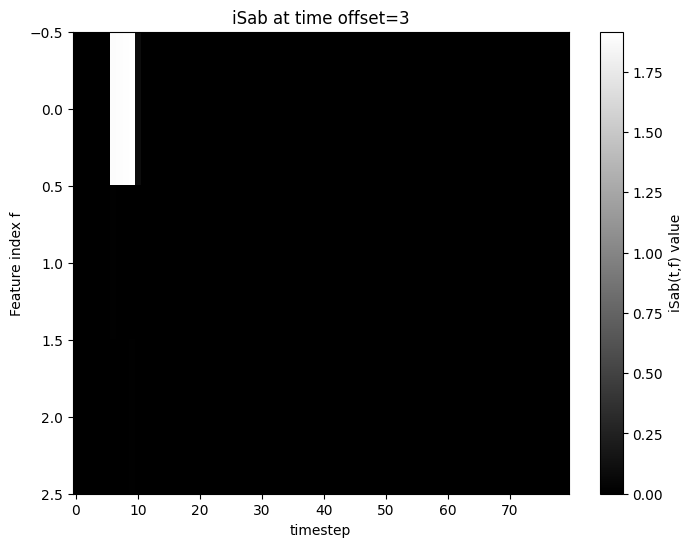

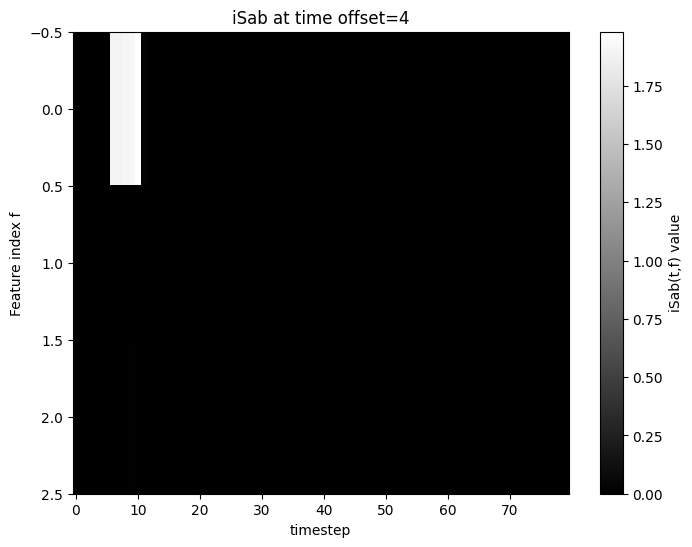

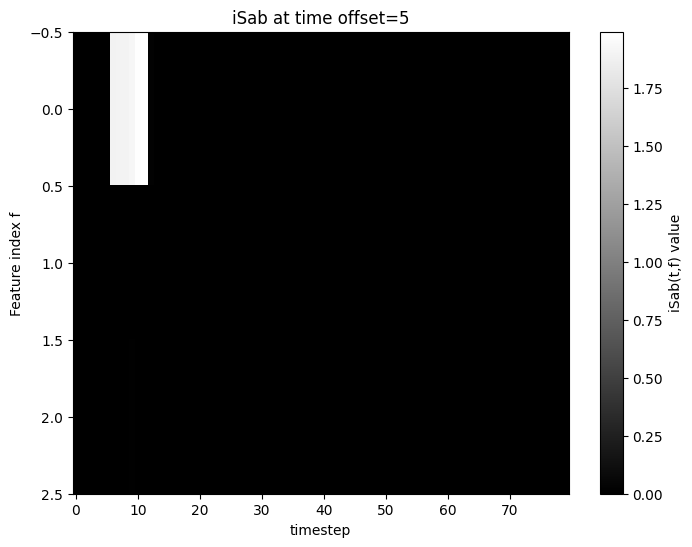

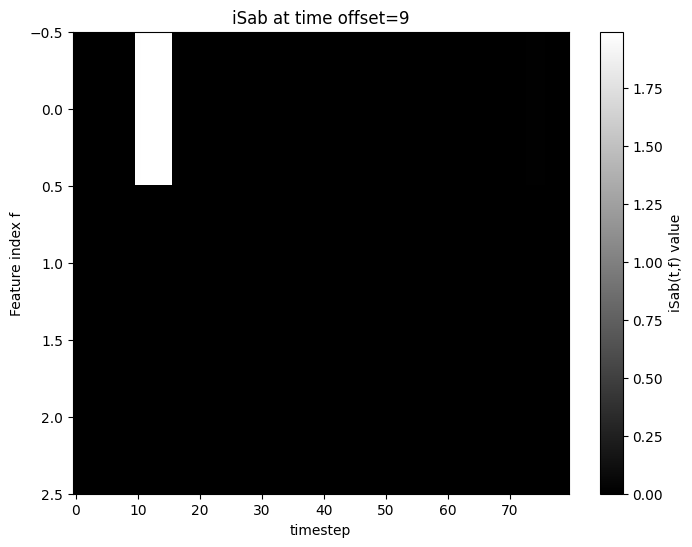

In [23]:
#iSab at different offsets
offset = 0
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()
offset = 1
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()
offset = 2
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()
offset = 3
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()

offset = 4
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()

offset = 5
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()

offset = 9
plt.figure(figsize=(8, 6))
im = plt.imshow(iSab_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="iSab(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"iSab at time offset={offset}")
plt.show()




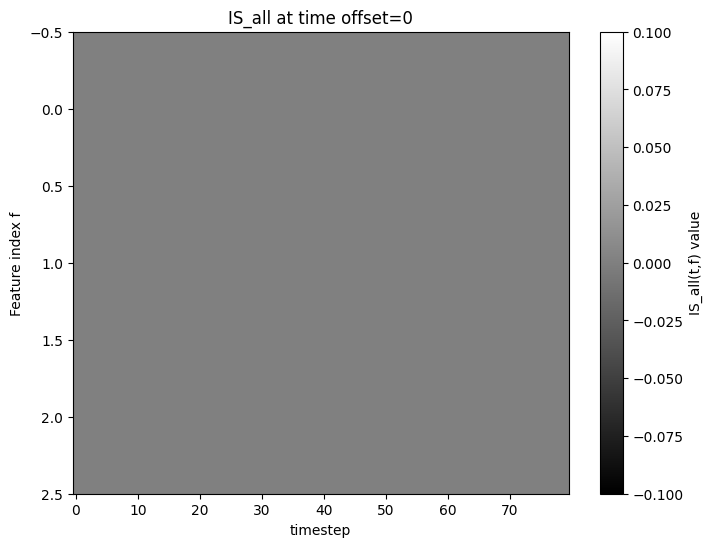

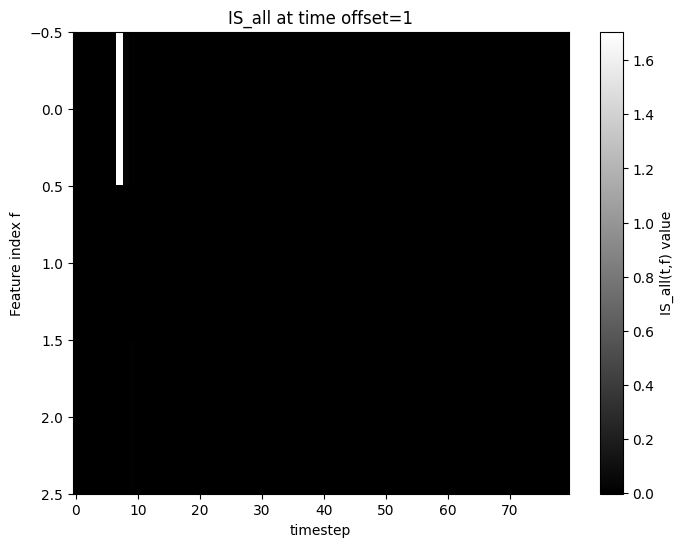

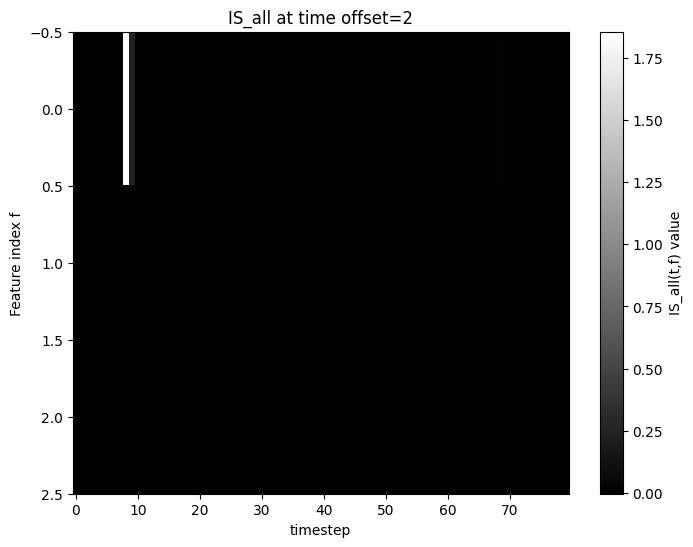

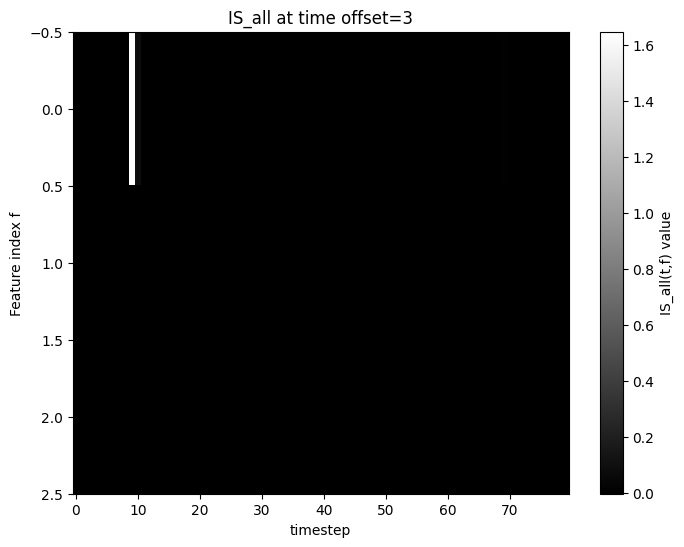

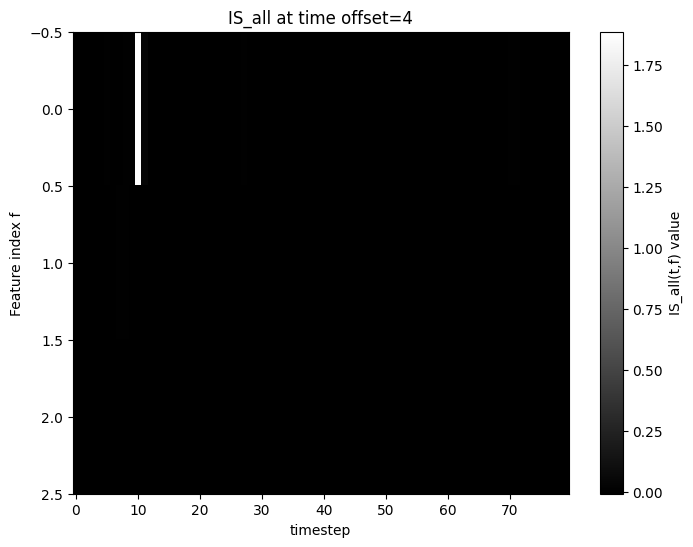

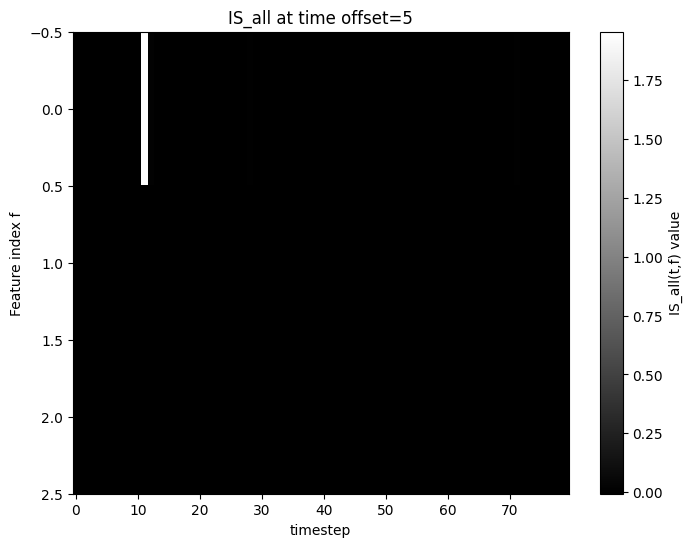

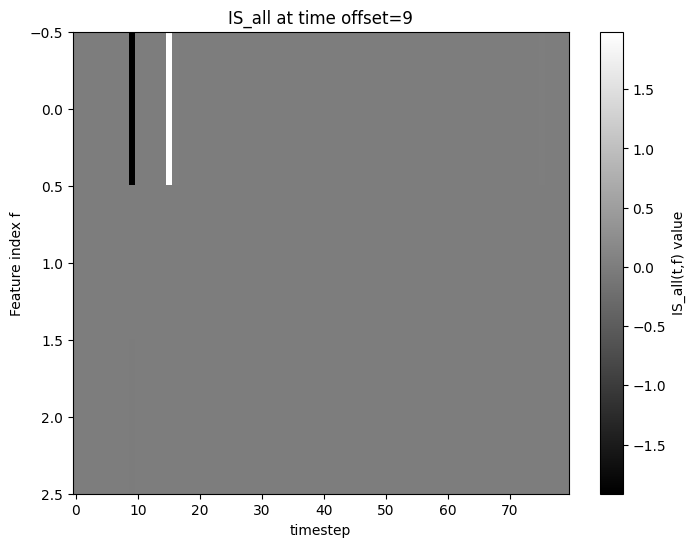

In [45]:
#iSab at different offsets
offset = 0
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()
offset = 1
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()
offset = 2
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()
offset = 3
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()

offset = 4
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()

offset = 5
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()

offset = 9
plt.figure(figsize=(8, 6))
im = plt.imshow(IS_all[:, :, offset], aspect='auto', cmap='gray')
plt.colorbar(im, label="IS_all(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f"IS_all at time offset={offset}")
plt.show()




(3, 80, 10)
(3, 80, 4)


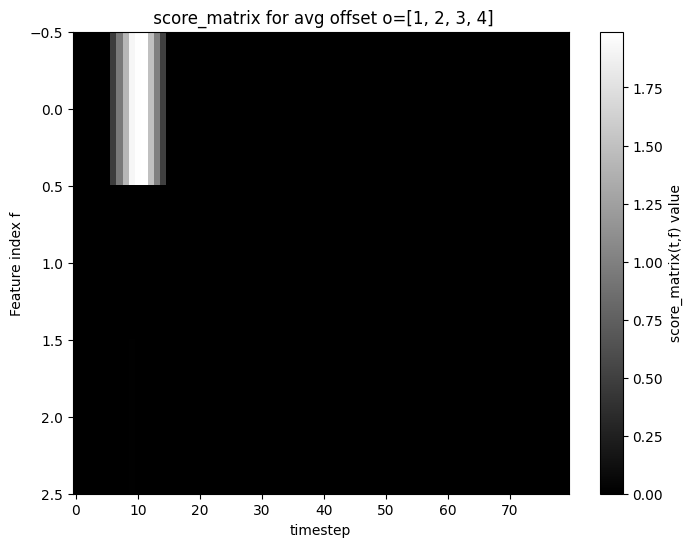

In [28]:
# compare against the final_score obtained
print(scores.shape) #(b,f,t,w)

offsets = [1,2,3,4]

print(scores[ :, :, offsets].shape)
score_matrix = scores[ :, :, offsets].mean(axis=2)


plt.figure(figsize=(8, 6))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
                # vmin=vmin,
                # vmax=vmax
                )

# cbar = plt.colorbar(im, label="score_matrix(t, f) value")
# cbar.set_clim(0, 2)  # enforce the same limits on the colorbar
plt.colorbar(im, label="score_matrix(t,f) value")
plt.xlabel("timestep")
plt.ylabel("Feature index f")
plt.title(f" score_matrix for avg offset o={offsets}")
plt.show()


In [31]:
iSab_all.shape

(3, 80, 10)

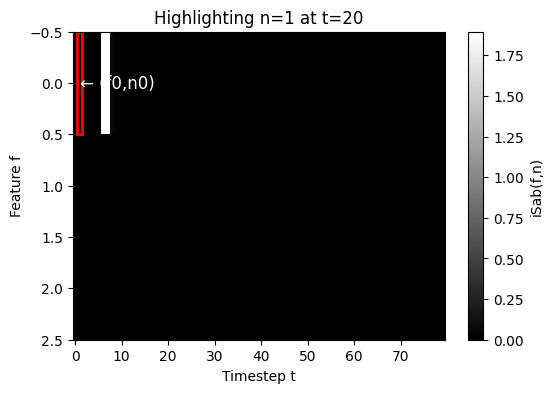

In [36]:
# Cell 4: Overlay “which cells” correspond to a particular (feature f0, offset n0):
n0 = 1
f0 = 0
plt.figure(figsize=(6, 4))
im = plt.imshow(iSab_all[:,:, n0], aspect="auto", cmap="gray")
plt.colorbar(im, label="iSab(f,n)")
# draw a red rectangle around cell (f0, n0)
rect = plt.Rectangle((n0 - 0.5, f0 - 0.5), 1, 1, edgecolor="red", facecolor="none", lw=2)
plt.gca().add_patch(rect)
plt.text(n0, f0, "← (f0,n0)", color="white", va="center", ha="left", fontsize=12)
plt.xlabel("Timestep t")
plt.ylabel("Feature f")
plt.title(f"Highlighting n={n0} at t={t0}")
plt.show()


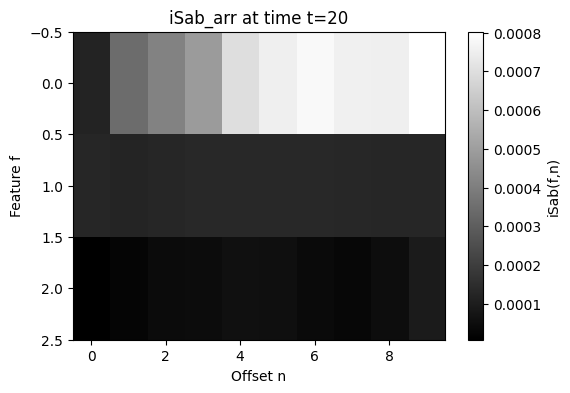

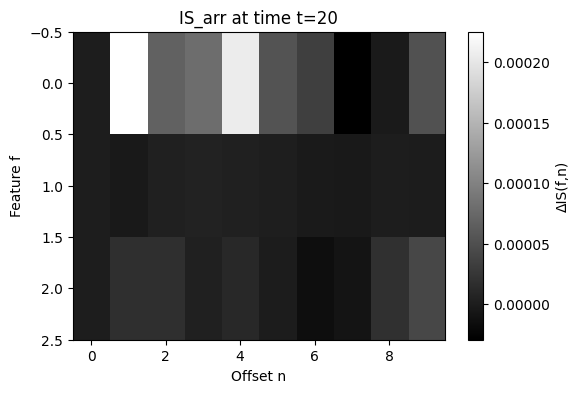

In [40]:
# Cell 5: Visualize iSab_arr at the same t0
iSab_arr = iSab_all[:,t0,:]  # shape (f × w_max)

plt.figure(figsize=(6, 4))
im2 = plt.imshow(iSab_arr, aspect="auto", cmap="gray")
plt.colorbar(im2, label="iSab(f,n)")
plt.xlabel("Offset n")
plt.ylabel("Feature f")
plt.title(f"iSab_arr at time t={t0}")
plt.show()

# Cell 5: Visualize iS_array (differenced) at the same t0
IS_arr = IS_all[:,t0,:]  # shape (f × w_max)

plt.figure(figsize=(6, 4))
im2 = plt.imshow(IS_arr, aspect="auto", cmap="gray")
plt.colorbar(im2, label="ΔIS(f,n)")
plt.xlabel("Offset n")
plt.ylabel("Feature f")
plt.title(f"IS_arr at time t={t0}")
plt.show()


In [43]:
scores.shape

(3, 80, 10)

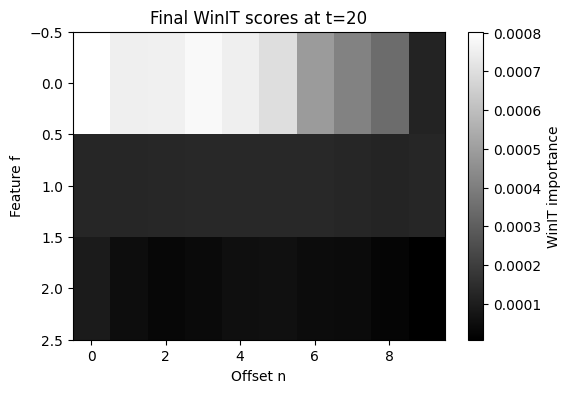

In [44]:
# Cell 7: Visualize the final WinIT “score tensor” for sample index=0
# final_scores shape: (1, f, T, w_max). Drop batch‐axis ⇒ (f, T, w_max)

t_show = 20            # pick a time slice to visualize (f × w_max)
slice_f_w = scores[ :, t_show, :]  # shape (f × w_max)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im3 = ax.imshow(slice_f_w, aspect="auto", cmap="gray")
ax.set_title(f"Final WinIT scores at t={t_show}")
ax.set_xlabel("Offset n")
ax.set_ylabel("Feature f")
plt.colorbar(im3, label="WinIT importance")
plt.show()

# Optionally, show how the full 4D tensor could be “rolled out”
# into a large grid of (time × window) vs feature, but that can be memory‐heavy.


### Plots over time

NameError: name 'iS_array_all' is not defined

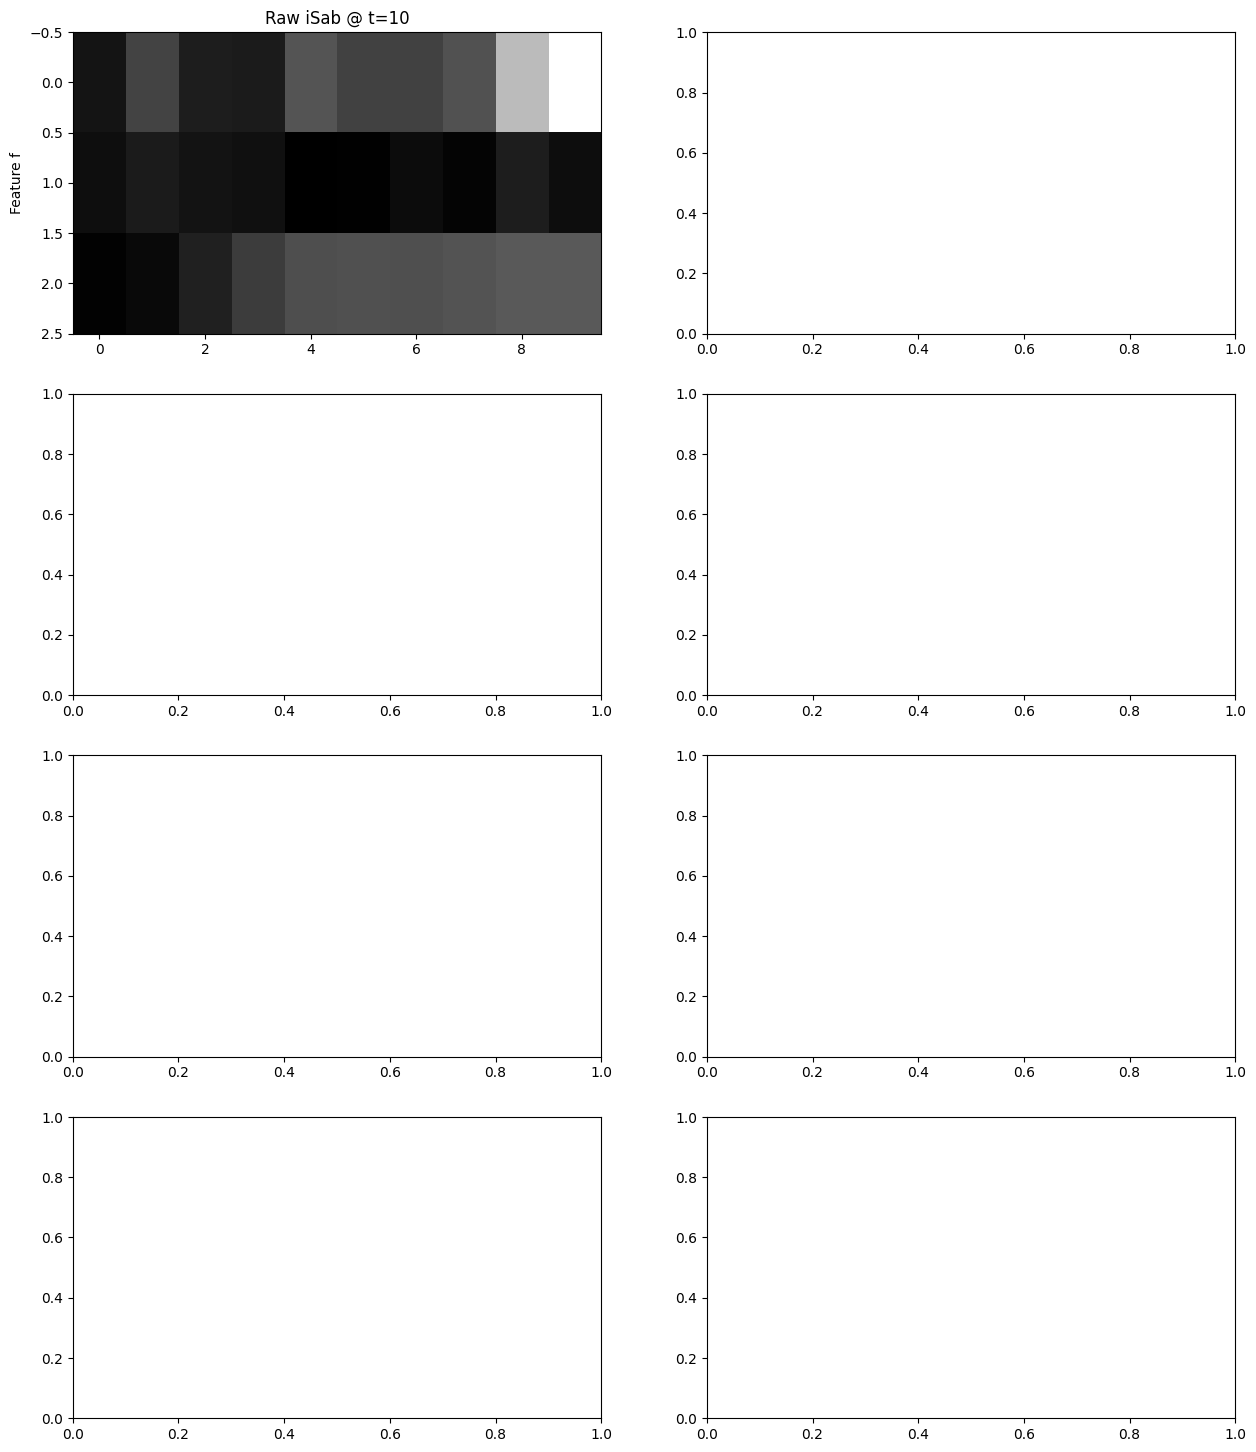

In [47]:
# Cell 6: Show how “window size” changes the shape of iS_array over all t
# We’ll plot a small grid of snapshots at t = [10, 20, 30, 40], for instance.
times_to_plot = [10, 20, 30, 40]
n_rows = len(times_to_plot)
n_cols = 2  # one for raw iSab, one for iS_array
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 18))

for r, t_plot in enumerate(times_to_plot):
    # raw iSab
    im0 = axes[r, 0].imshow(iSab_all[t_plot,:,:,0], aspect="auto", cmap="gray")
    axes[r, 0].set_title(f"Raw iSab @ t={t_plot}")
    if r == n_rows - 1:
        axes[r, 0].set_xlabel("Offset n")
    axes[r, 0].set_ylabel("Feature f")

    # differenced iS_array
    im1 = axes[r, 1].imshow(iS_array_all[t_plot], aspect="auto", cmap="gray")
    axes[r, 1].set_title(f"Differenced ΔI @ t={t_plot}")
    if r == n_rows - 1:
        axes[r, 1].set_xlabel("Offset n")
    # no y‐label on right column

# Add a colorbar on the right side for all iS_array subplots
fig.colorbar(im1, ax=axes[:, 1], orientation="vertical", fraction=0.02, label="ΔI")

# plt.tight_layout()
plt.show()


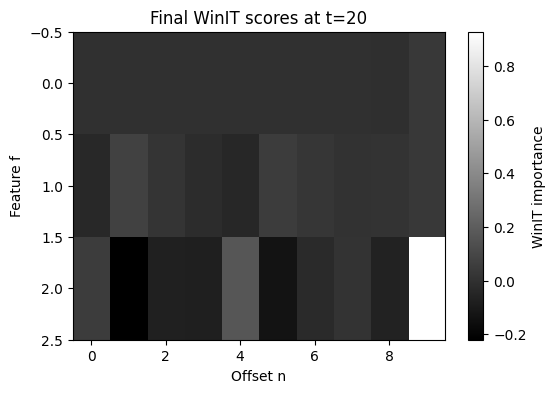

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Assume iSab_all is already computed and has shape (T, F, w_max)
num_timesteps = len(iSab_all)
num_features = iSab_all[0].shape[0]
w_max        = iSab_all[0].shape[1]

# Build full_iSab[f, t, n]
full_iSab = np.zeros((num_features, num_timesteps, w_max))
for t in range(num_timesteps):
    raw_mat = iSab_all[t]  # shape (F, w_max)
    w_t = raw_mat.shape[1]
    full_iSab[:, t, :w_t] = raw_mat

offsets_to_plot = list(range(w_max))  # all offsets

n_cols = 3
n_rows = int(np.ceil(len(offsets_to_plot) / n_cols))

# Here we set height_ratios so each row is relatively short
height_ratios = [100]*n_rows # all rows equal, but figure height is small
fig, axes = plt.subplots(
    n_rows, n_cols, 
    figsize=(4 * n_cols, 1 * n_rows),  # smaller total height
    sharex=True, sharey=True,
    gridspec_kw={'height_ratios': height_ratios}
)
axes = axes.flatten()

for idx, n in enumerate(offsets_to_plot):
    ax = axes[idx]
    mat = full_iSab[:, :, n]  # shape (F, T)
    im = ax.imshow(mat, aspect='auto', cmap='gray', origin='lower')
    ax.set_title(f"Offset n = {n}", fontsize=10)
    ax.set_ylabel("Feature f", fontsize=8)
    ax.set_xlabel("Time t", fontsize=8)
    ax.set_yticks(np.arange(num_features))
    ax.set_yticklabels(np.arange(num_features), fontsize=6)
    ax.set_xticks(np.linspace(0, num_timesteps - 1, 5).astype(int))
    ax.set_xticklabels(
        np.linspace(0, num_timesteps - 1, 5).astype(int), 
        fontsize=6
    )
    # individual colorbar (optional, but you can omit if you want to save space)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=6)

# Hide any extra axes
for j in range(len(offsets_to_plot), n_rows*n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


ValueError: could not broadcast input array from shape (3,10,128) into shape (3,10)

In [21]:
# Cell: For each offset n, plot iSab heatmap (feature × time) and adjoining schematic grid highlighting (feature f0, time window)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assume iSab_all has shape [T][F, w_max], and we know num_features, num_timesteps, w_max
num_timesteps = len(iSab_all)
num_features = iSab_all[0].shape[0]
w_max        = iSab_all[0].shape[1]

# Build full_iSab[f, t, n] as before
full_iSab = np.zeros((num_features, num_timesteps, w_max))
for t in range(num_timesteps):
    raw_mat = iSab_all[t]  # shape (F, w_max)
    w_t = raw_mat.shape[1]
    full_iSab[:, t, :w_t] = raw_mat

# Choose offsets to visualize and a feature of interest f0
offsets_to_plot = list(range(w_max))  # e.g. [0,1,...,w_max-1]
f0 = 2       # pick a specific feature index to highlight
t0 = 20      # pick a fixed time index

n_rows = len(offsets_to_plot)
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 2 * n_rows),
                         gridspec_kw={'width_ratios':[2, 1]})

for row, n in enumerate(offsets_to_plot):
    # --- Left: iSab heatmap for offset n (feature × time) ---
    ax_hm = axes[row, 0]
    mat = full_iSab[:, :, n]  # shape (F, T)
    im = ax_hm.imshow(mat, aspect='auto', cmap='gray', origin='lower')
    ax_hm.set_title(f"iSab (f × t) at offset n={n}", fontsize=10)
    ax_hm.set_ylabel("Feature f", fontsize=8)
    ax_hm.set_xlabel("Time t", fontsize=8)
    ax_hm.set_yticks(np.arange(num_features))
    ax_hm.set_yticklabels(np.arange(num_features), fontsize=6)
    ax_hm.set_xticks(np.linspace(0, num_timesteps - 1, 5).astype(int))
    ax_hm.set_xticklabels(
        np.linspace(0, num_timesteps - 1, 5).astype(int), 
        fontsize=6
    )
    # Colorbar
    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=6)

    # --- Right: schematic grid with highlighted box for (f0, [t0-n .. t0]) ---
    ax_sch = axes[row, 1]
    # Draw light gray grid
    ax_sch.set_xlim(-0.5, num_timesteps - 0.5)
    ax_sch.set_ylim(-0.5, num_features - 0.5)
    ax_sch.set_xticks(np.arange(0, num_timesteps, 1))
    ax_sch.set_yticks(np.arange(0, num_features, 1))
    ax_sch.set_xticklabels([], fontsize=0)  # hide tick labels
    ax_sch.set_yticklabels([], fontsize=0)
    ax_sch.grid(color='lightgray', linewidth=0.5)

    # Compute window start and end
    start = max(t0 - n, 0)
    end = t0

    # Draw colored rectangle at row f0, columns start..end
    rect = Rectangle(
        (start - 0.5, f0 - 0.5),    # lower-left corner
        width=(end - start + 1),    # spans those time steps
        height=1, 
        facecolor='red', 
        alpha=0.3
    )
    ax_sch.add_patch(rect)
    ax_sch.set_title(f"Schematic: f={f0}, t∈[{start},{end}]", fontsize=8)
    ax_sch.set_xlabel("Time t", fontsize=8)
    ax_sch.set_ylabel("Feature f", fontsize=8)
    ax_sch.set_xlim(-0.5, num_timesteps - 0.5)
    ax_sch.set_ylim(-0.5, num_features - 0.5)

    # Draw a bold border around the highlighted feature row for clarity
    ax_sch.add_patch(Rectangle(
        (-0.5, f0 - 0.5),
        num_timesteps,
        1,
        edgecolor='black',
        facecolor='none',
        linewidth=1
    ))

plt.tight_layout()
plt.show()


ValueError: could not broadcast input array from shape (3,10,128) into shape (3,10)

### Plot of score

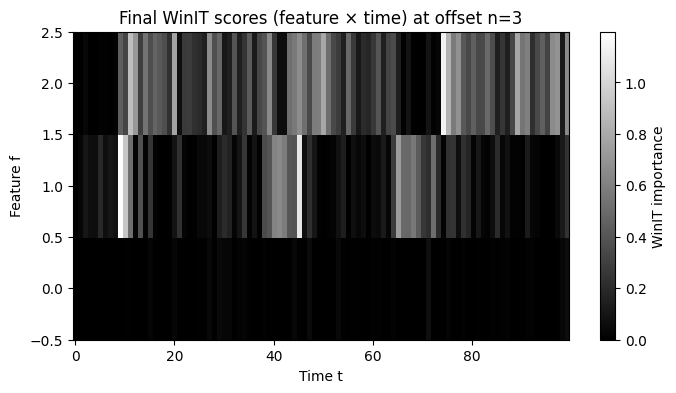

In [23]:
# final_scores shape is (1, F, T, w_max)
attr = scores[0]  # drop batch dimension → shape (F, T, w_max)

import matplotlib.pyplot as plt

# Choose an offset, e.g. n0 = 3
n0 = 3
slice_f_t = attr[:, :, :].mean(axis = 2)  # shape (F, T)

plt.figure(figsize=(8, 4))
im = plt.imshow(slice_f_t, aspect='auto', cmap='gray', origin='lower')
plt.colorbar(im, label="WinIT importance")
plt.xlabel("Time t")
plt.ylabel("Feature f")
plt.title(f"Final WinIT scores (feature × time) at offset n={n0}")
plt.show()
